In [ ]:
pip install git+https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.primitives import Estimator
from qiskit.circuit import ParameterVector 
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
import warnings
from ECC2025.testing import test_6a, test_6b, test_6c
warnings.filterwarnings("ignore")

El Variational Quantum Eigensolver (VQE) puede ser aplicado para estudíar sistemas cuánticos complejos. Consideremos el modelo de Schwinger, el cual describe la creacion y aniquilación de electrones y positrones. Este modelo debe su nombre a Julian Seymour Schwinger, ganador del premio Nobel en física en 1965, y es muy estudiado como modelo de juguete en Cronodinámica Cuántica. Supongamos que tenemos una region del espacio unidimensional donde hay campo electromagnético, y que discretizamos esta región en $N/2$ sitios donde colocamos partículas cargadas, es decir, electrones o positrones. Cada uno de estos sitios estará representado por dos qubit, siendo el estado $|00\rangle$ es un electro, $|11\rangle$ un positron, $|10\rangle$ el vacío , y $|01\rangle$ un electrón y un positrón. Estas partículas interactúan entre ellas debido a su carga y al campo electromagnético externo. El Hamiltoniano que describe esta situación es:

$$ H = g\sum_{j=0}^{N-2}\left( \sigma_+^{(j)}\sigma_-^{(j+1)} +\sigma_-^{(j)}\sigma_+^{(j+1)} \right) + \frac{m}{2}\sum_{j=0}^{N-1}(-1)^j\sigma_z^{(j)} + b\sum_{j=0}^N L_j^2 $$

El primer termino es responsable de la interacción $w$ de las partículas, el segundo depende de la masa $m$ de las partículas, y el último es el campo electromagnetico externo $g$, donde
$$ L_j = l - \frac{1}{2}\sum_{k=0}^{j} \left( \sigma_z^{(k)}+(-I)^l \right),$$
con $l$ el campo externo constante. En este desafío obtendremos el estado de minima energía y el primer estado excitado de este Hamiltoniano.

__Desafio:__ Complete la siguiente función que implementa el Hamiltoniano de Schinger. Hemos programado el primer término del Hamiltoniano, por lo que usted debe programar los dos restantes. Utilice la función ``Pauli(z,x)`` para implementar un operador de Pauli de $N$ qubits, donde ``x`` e ``y`` son vectores de tamaño $N$ de de elementos 0 y 1. Las entrada $j$ de estos vectores permiten especificar el operador de Pauli en el qubit $j$:

i) $z=0$, $x=0$, $\rightarrow I$

ii) $z=0$, $x=1$, $\rightarrow X$

iii) $z=1$, $x=1$, $\rightarrow Y$

iv) $z=1$, $x=0$, $\rightarrow Z$

Suponga que $g=b=1$. 

In [33]:
def H_Schwinger( Nq, m ):
    ops  = []
    coef = []
    for j in range(Nq-1):
        x = np.zeros(Nq)
        z = np.zeros(Nq)
        x[j]   = 1
        x[j+1] = 1
        ops.append( Pauli((z,x)) )
        coef.append(1)
        z[j]   = 1
        z[j+1] = 1
        ops.append( Pauli((z,x)) )
        coef.append(1)

    ####### Escribe tu solucion aca ##########    
    for j in range(Nq):
        x = np.zeros(Nq)
        z = np.zeros(Nq)
        z[j] = 1
        ops.append( Pauli((z,x)) )
        coef.append( 0.5*m*(-1)**j )

    for j in range(Nq-1):
        for k1 in range(j):
            for k2 in range(j):             
                x = np.zeros(Nq)
                z = np.zeros(Nq)

                ops.append( Pauli((z,x)) )
                coef.append( (-1)**(k1+k2) )

                z[k1] = 1
                ops.append( Pauli((z,x)) )
                coef.append( (-1)**k2 )

                z[k2] = 1
                ops.append( Pauli((z,x)) )
                coef.append( 1 )

                z[k1] = 0
                ops.append( Pauli((z,x)) )
                coef.append( (-1)**k1 )
    #################################################
    H = SparsePauliOp( ops, coef ).simplify()
    return H 

In [34]:
test_6a( H_Schwinger )

Felicidades, tu Hamiltoniano esta correcto!


__Desafio:__ Complete el siguiente circuito para que implementa un ansatz variacional a su elección para el Hamiltoniano de Schwinger para $N=4$ qubits. Solo puede utilizar puertas ``ry`` y ``cx``, y debe ser lo suficientemente expresivo para encontrar una buena aproximación del mínimo de energía.

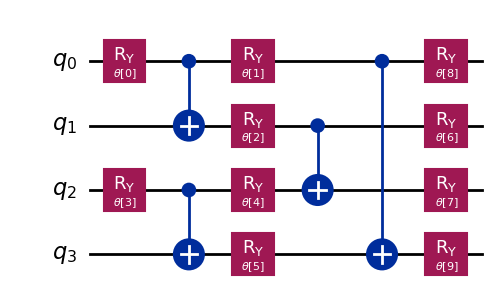

In [35]:
var_ansatz = QuantumCircuit(4)

######## Escriba su solución acá ##########
theta = ParameterVector(r'$\theta$',10)

var_ansatz.ry(theta[0],0)
var_ansatz.cx(0,1)
var_ansatz.ry(theta[1],0)
var_ansatz.ry(theta[2],1)

var_ansatz.ry(theta[3],2)
var_ansatz.cx(2,3)
var_ansatz.ry(theta[4],2)
var_ansatz.ry(theta[5],3)

var_ansatz.cx(1,2)
var_ansatz.ry(theta[6],1)
var_ansatz.ry(theta[7],2)

var_ansatz.cx(0,3)
var_ansatz.ry(theta[8],0)
var_ansatz.ry(theta[9],3)
#####################################

var_ansatz.draw('mpl') 

In [36]:
def VQE4Schwinger( m, plot=True ):

    if var_ansatz.num_parameters == 0 :
        E = 0
    else:

        H = H_Schwinger( 4, m )
        optimizer = COBYLA(maxiter=500)

        counts = []
        values = []
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)

        quantum_solver = VQE( Estimator(), var_ansatz, optimizer, 
                                callback=store_intermediate_result )
        np.random.seed(0)
        result = quantum_solver.compute_minimum_eigenvalue(operator=H)
        E = result.eigenvalue.real 

        if plot:
            H = H_Schwinger( 4 ,0 )
            vals, vecs = np.linalg.eigh( H.to_matrix() )
            plt.plot( counts, values )
            plt.hlines(vals[0], 0, 500, color='tab:orange')
            plt.xlabel('Evaluaciones')
            plt.ylabel('Energía')
            plt.legend(['VQE', 'Energía Mínima'])

    return E

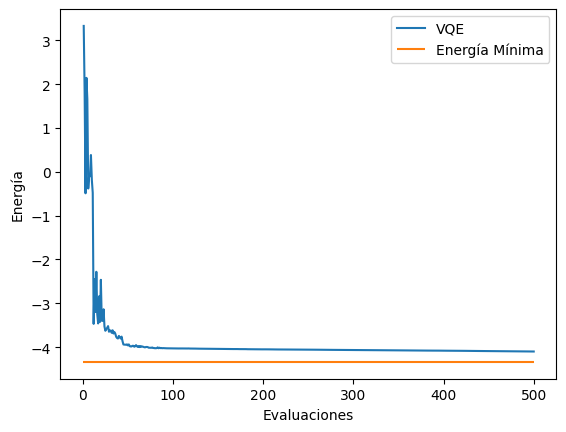

In [37]:
E = VQE4Schwinger(0) 

In [38]:
def test_6b(H_Schwinger,var_ansatz):
    
    sol = True
    if var_ansatz.num_parameters == 0 :
        print('Tu circuito no tiene parametros.')
        sol = False 

    for op in var_ansatz.count_ops().keys():
        if op in ['ry', 'cx']:
            pass
        else:
            print('Estas usando una puerta no permitida.')

    def VQE4Schwinger( m, plot=True ):

        if var_ansatz.num_parameters == 0 :
            E = 0
        else:
            np.random.seed(0)
            H = H_Schwinger( 4, m )
            optimizer = COBYLA(maxiter=500)

            counts = []
            values = []
            def store_intermediate_result(eval_count, parameters, mean, std):
                counts.append(eval_count)
                values.append(mean)

            quantum_solver = VQE( Estimator(), var_ansatz, optimizer, 
                                    initial_point = 0.1*np.ones(var_ansatz.num_parameters), 
                                    callback=store_intermediate_result )
            result = quantum_solver.compute_minimum_eigenvalue(operator=H)
            E = result.eigenvalue.real 

            if plot:
                plt.plot( counts, values )
                plt.xlabel('Evaluaciones')
                plt.ylabel('Energía')

        return E

    ms =  np.linspace( -5, 5, 21) 

    E_np = []
    for m in ms:
        H = H_Schwinger( 4 , m )
        vals, vecs = np.linalg.eigh( H.to_matrix() )
        E_np.append(vals[0])
    E_np = np.array(E_np)

    E_vs_m = [ VQE4Schwinger(m, False) for m in ms ]
    plt.plot( ms, E_vs_m, '-o' )
    plt.plot( ms, E_np )
    plt.xlabel('masa')
    plt.ylabel('Energía')
    plt.legend(['VQE', 'Energía Mínima'])

    if np.linalg.norm( E_vs_m - E_np ) > 2:
        print('Tu circuito variación no es suficientemente expresivo para encontrar la solución')
        sol = False 

    if sol:
        print('Tu solución esta correcta!')

Tu solución esta correcta!


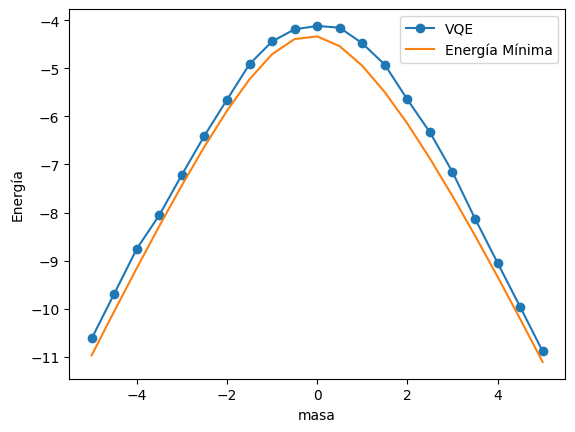

In [39]:
test_6b(H_Schwinger,var_ansatz)

Este Hamiltoniano exhibe una transición de fase para $m=-1/2$. Para esta masa el estado de minima energía es inestable, así que decae a un estado con masa negativa o positiva. Para masas pasitivas tenemos que el par electron-positron se aniquilan, mientras que para masas negativas forman un estado ligado.???

Podemos estimar el primer estado excitado de un Hamiltoniano con el Concurrent VQE. Este se basa en minimizar la función objetivo:
$$ \bar{E}(\theta) = \frac{1}{2}\left( \langle 0000 | U(\theta)^\dagger H U(\theta) |0000\rangle + \langle 1000 | U(\theta)^\dagger H U(\theta) |1000\rangle \right). $$
Esta función objetivo puede estimarse introduciendo un qubit auxiliar, y preparando el circuito variacional
$$ |\bar{\psi}(\theta)\rangle = |0\rangle\otimes U(\theta)|0000\rangle + |1\rangle\otimes U(\theta)|1000\rangle, $$
y midiendo $H$ sobre los dos primeros qubits.

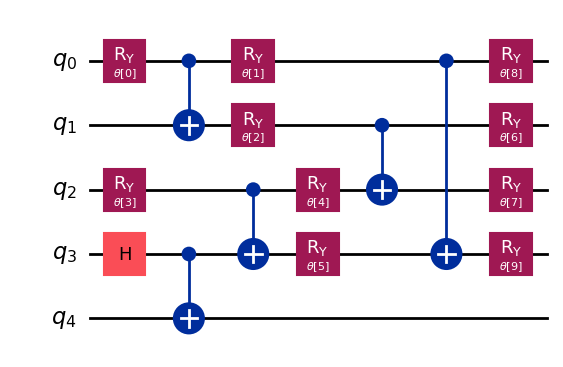

In [40]:
def H_Schwinger_cvqe( N, m ):

    H = SparsePauliOp( [(N+1)*'I'], [0] ) # Este H es solo por default. Debes redefinirlo.

    ##### Escriba su solución acá #######
    H =  SparsePauliOp(['I'],[1])^H_Schwinger( 4, m )
    ####################################

    return H

var_ansatz_cvqe = QuantumCircuit(5)

####### Escriba su solución acá #######
var_ansatz_cvqe.h(3)
var_ansatz_cvqe.cx(3,4)
var_ansatz_cvqe.compose( var_ansatz, range(4), inplace=True)
#######################################

var_ansatz_cvqe.draw('mpl')

In [41]:
def CVQE4Schwinger( m, plot=True ):

    if var_ansatz_cvqe.num_parameters == 0 :
        E = 0
    else:
        np.random.seed(0)

        H = H_Schwinger_cvqe( 4, m )        
        optimizer = COBYLA(maxiter=500)

        counts = []
        values = []
        def store_intermediate_result(eval_count, parameters, 
                                        mean, std):
            counts.append(eval_count)
            values.append(mean)

        quantum_solver = VQE( Estimator(), var_ansatz_cvqe, optimizer, 
                                initial_point = 0.1*np.ones(var_ansatz.num_parameters), 
                                callback=store_intermediate_result,
                                )
        result = quantum_solver.compute_minimum_eigenvalue(
                                operator=H )
        E = result.eigenvalue.real 
        
        if plot:
            H = H_Schwinger( 4 , m )
            vals, vecs = np.linalg.eigh( H.to_matrix() )
            plt.plot( counts, values )
            plt.hlines( np.mean( vals[:2] ), 0, 500, color='tab:orange' )
            plt.xlabel('Evaluaciones')
            plt.ylabel('Energía')

    ##############################

    return E 

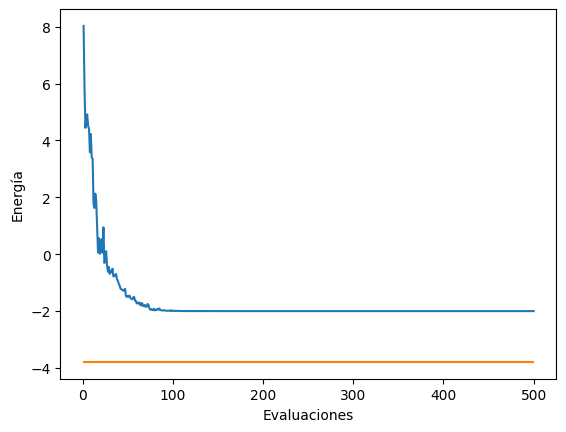

In [42]:
E = CVQE4Schwinger( 0 ) 

In [49]:
def test_6c( H_Schwinger, CVQE4Schwinger, VQE4Schwinger ):
    ms =  np.linspace( -5, 5, 21) 

    E_np = []
    for m in ms:
        H = H_Schwinger( 4 , m )
        vals, vecs = np.linalg.eigh( H.to_matrix() )
        E_np.append(vals[:2])
    E_np = np.array(E_np)

    E_vs_m = [ VQE4Schwinger(m, False) for m in ms ]
    E0_plus_E1_vs_m = 2*np.array([ CVQE4Schwinger(m, False) for m in ms ])
    E1_vs_m = np.array(E0_plus_E1_vs_m) - np.array(E_vs_m)
    plt.plot( ms, E_vs_m, ':o', color='tab:blue' )
    plt.plot( ms, E1_vs_m, ':o', color='tab:orange' )
    plt.plot( ms, E_np[:,0], color='tab:blue' )
    plt.plot( ms, E_np[:,1], color='tab:orange' )
    plt.xlabel('masa')
    plt.ylabel('Energía')
    plt.legend([ 'Mínimo VQE', 'Excitado CVQE', 
                'Mínimo Exacto', 'Excitado Exacto' ]) 

    if np.mean( np.abs( E_np - np.array([ E_vs_m, E1_vs_m ]).T )**2 ) < 1:
        print('Tu solución esta correcta')
    else:
        print('Tu solución esta incorrecta.', 
                np.mean( np.abs( E_np - np.array([ E_vs_m, E1_vs_m ]).T )**2 ) )

Tu solución esta correcta


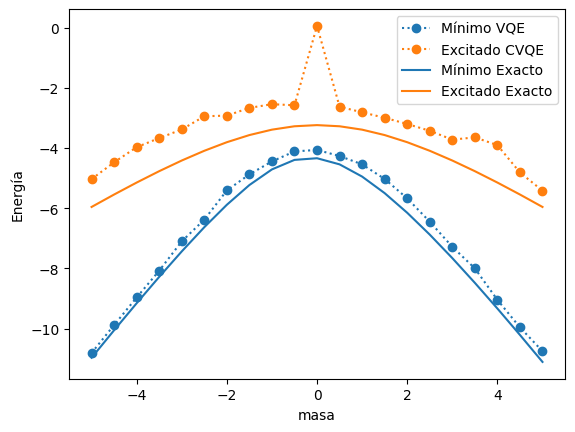

In [50]:
test_6c( H_Schwinger, CVQE4Schwinger, VQE4Schwinger ) 